# Tutorial 4

## Planetary Injection-Recovery Test

This tutorial demonstrates how `ARVE` can be used to perform planetary injection-recovery tests on the measured radial velocities (RVs).

We begin by importing the `ARVE` package and other useful packages.

In [1]:
# Import packages
import arve
import matplotlib.pyplot as     plt
from   matplotlib.ticker import AutoMinorLocator
import numpy             as     np
import pandas            as     pd

For our analysis, we make use of RVs from the HARPS-N solar telescope, downloadable from [DACE](https://dace.unige.ch/sun).

In [2]:
# Read RVs
df = pd.read_csv("example_data/tutorial_4/harpn_sun_release_timeseries_2015-2018.csv")
time_val_tot = df["date_bjd"].values
vrad_val_tot = df["rv"      ].values
vrad_err_tot = df["rv_err"  ].values

# Scale from m/s to km/s
vrad_val_tot *= 1e-3
vrad_err_tot *= 1e-3
vrad_val_tot -= np.nanmedian(vrad_val_tot)

To make the injection-recovery test computationally efficient, we bin the measurements by day to have fewer data points.

In [3]:
# Arrays for binned data
time_min = int(time_val_tot[ 0]-0.5)+0.5
time_max = int(time_val_tot[-1]+0.5)+0.5
time_del = 1
time_bin = np.arange(time_min, time_max+time_del/2, time_del)
time_val = np.zeros_like(time_bin)*np.nan
vrad_val = np.zeros_like(time_bin)*np.nan
vrad_err = np.zeros_like(time_bin)*np.nan

# Loop bins
for i in range(len(time_bin)-1):

    # Find index range
    idx_min = np.searchsorted(time_val_tot, time_bin[i]  )
    idx_max = np.searchsorted(time_val_tot, time_bin[i+1])
    idx_bin = np.arange(idx_min, idx_max)

    # Compute weighted average if current bin has enough points
    if len(idx_bin) > 5:
        time_val[i] = np.average(time_val_tot[idx_bin], weights=1/vrad_err_tot[idx_bin]**2)
        vrad_val[i] = np.average(vrad_val_tot[idx_bin], weights=1/vrad_err_tot[idx_bin]**2)
        vrad_err[i] = (np.sum(1/vrad_err_tot[idx_bin]**2))**(-1/2)

# Remove empty binned measurements
idx_val  = ~np.isnan(time_val)
time_val = time_val[idx_val]
vrad_val = vrad_val[idx_val]
vrad_err = vrad_err[idx_val]

First, we can plot the RVs to see the signatures of the solar rotation and magnetic cycle.

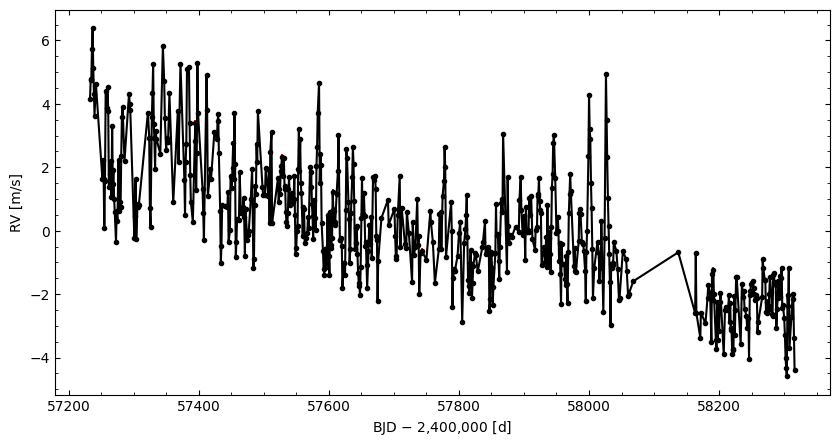

In [4]:
# Plot RV time series
plt.figure(figsize=(10,5))
plt.errorbar(time_val, vrad_val*1e3, vrad_err*1e3, fmt=".", ls="-", color="k", ecolor="r")
plt.xlabel("BJD $-$ 2,400,000 [d]")
plt.ylabel("RV [m/s]")
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(axis="both", which="both", direction="in", top=True, right=True)
plt.show()

To perform the injection-recovery test, we initiate an `ARVE` object and provide it the relevant data. We thereafter select a map of planetary periods and masses to be injected, and perform the test.

In [5]:
# Initiate ARVE object and perform injection-recovery test
example = arve.ARVE()
example.star.target = "Sun"
example.star.get_stellar_parameters()
example.data.add_data(time_val=time_val, vrad_val=vrad_val, vrad_err=vrad_err)
example.planets.injection_recovery(xy_map=[1e1,1e3,1e0,1e2], map_dim=[21,21], x_var="P", y_var="m", scale="log", N_max=3)

Once the test has been executed, the resulting recoveries can be plotted, where it becomes clear that the stellar variability limits the detection of low-mass and long-period planets.

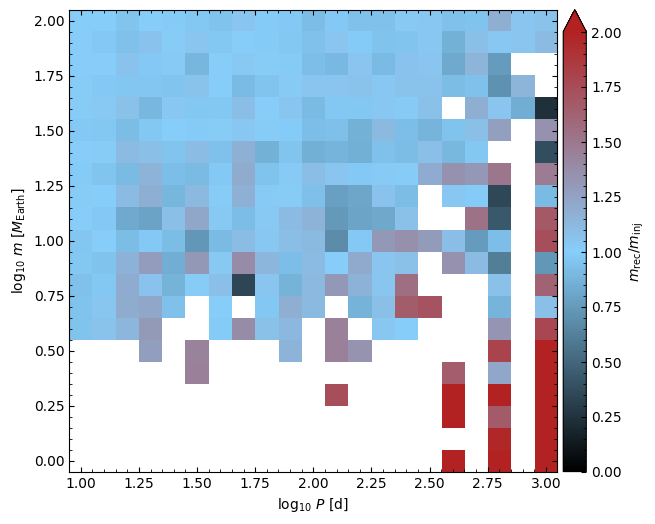

In [6]:
# Plot recovery map
fig = example.planets.plot_recoveries(figsize=(7.5,6.0))
plt.show(fig)